In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from scipy.optimize import minimize
from sklearn.metrics import average_precision_score


Using TensorFlow backend.


In [2]:

df = pd.read_csv('../../aparent/data/leslie_derti_apadb_features_pas_3_utr3.csv', sep='\t')

save_dict = np.load("../../aparent/data/leslie_derti_apadb_features_pas_3_utr3_no_x.npz")
m, l, c, y, _ = save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y'], save_dict['s']

save_dict = np.load("../../aparent/data/leslie_derti_apadb_features_pas_3_utr3_saluki_pmirGLO_construct.npz")
hl, hl_m = np.mean(save_dict['hl'], axis=-1), save_dict['hl_m']

a_rich = np.zeros(m.shape)
for k in range(m.shape[1]) :
    a_rich[:, k] = df['pas_exists_' + str(k)] & df['wide_seq_ext_' + str(k)].str.slice(175 - 70, 175 - 70 + 205).str.contains("AAAAAAAAAAAAA|AAAAAAGAAAAAA|AAAAAACAAAAAA")

#Define tissue-/cell- types

cell_types = np.array(['apadb_count_kidney',
       'apadb_count_pancreas',
       'apadb_count_monocytes',
       'apadb_count_all',
       'apadb_count_pdac',
       'apadb_count_prcc',
       'apadb_count_full_blood',
       'apadb_count_hlf',
       'apadb_count_pooled',
       'leslie_count_hek293',
       'leslie_count_mcf10a_hras2',
       'leslie_count_mcf10a1',
       'leslie_count_mcf10a2',
       'leslie_count_mcf10a_hras1',
       'leslie_count_bcells1',
       'leslie_count_mcf7',
       'leslie_count_bcells2',
       'leslie_count_ovary',
       'leslie_count_breast',
       'leslie_count_brain',
       'leslie_count_skmuscle',
       'leslie_count_blcl',
       'leslie_count_hES',
       'leslie_count_testis',
       'leslie_count_hela',
       'leslie_count_ntera',
       'leslie_count_pooled',
       'leslie_count_apadb_region_hek293',
       'leslie_count_apadb_region_mcf10a_hras2',
       'leslie_count_apadb_region_mcf10a1',
       'leslie_count_apadb_region_mcf10a2',
       'leslie_count_apadb_region_mcf10a_hras1',
       'leslie_count_apadb_region_bcells1',
       'leslie_count_apadb_region_mcf7',
       'leslie_count_apadb_region_bcells2',
       'leslie_count_apadb_region_ovary',
       'leslie_count_apadb_region_breast',
       'leslie_count_apadb_region_brain',
       'leslie_count_apadb_region_skmuscle',
       'leslie_count_apadb_region_blcl',
       'leslie_count_apadb_region_hES',
       'leslie_count_apadb_region_testis',
       'leslie_count_apadb_region_hela',
       'leslie_count_apadb_region_ntera',
       'leslie_count_apadb_region_pooled',
       'derti_count_brain',
       'derti_count_kidney',
       'derti_count_liver',
       'derti_count_maqc-brain1',
       'derti_count_maqc-brain2',
       'derti_count_maqc-UHR1',
       'derti_count_maqc-UHR2',
       'derti_count_muscle',
       'derti_count_testis',
       'derti_count_pooled',
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

#Slice celltypes

cell_type = 'apadb_count_pooled'

c = c[:, :, cell_type_dict[cell_type]]
y = y[:, :, cell_type_dict[cell_type]]

model_names = [
    'aparent-resnet',
    'aparent-resnet+hl',
    'aparent',
    'deerect-apa',
    'polyapred',
]

model_scores = [
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_theano_legacy_30_31_34_pasaligned_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/leslie_derti_apadb_features_pas_3_utr3_deerect_apa_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/leslie_derti_apadb_features_pas_3_utr3_polyapred_native_scores_shifted.npy'),
]

use_saluki = [
    False,
    True,
    False,
    False,
    False,
]

print("s.shape = " + str(model_scores[0].shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("y.shape = " + str(y.shape))
print("c.shape = " + str(c.shape))
print("")
print("hl.shape = " + str(hl.shape))
print("hl_m.shape = " + str(hl_m.shape))
print("a_rich.shape = " + str(hl_m.shape))


s.shape = (6944, 10)
m.shape = (6944, 10)
l.shape = (6944, 10)
y.shape = (6944, 10)
c.shape = (6944, 10)

hl.shape = (6944, 10)
hl_m.shape = (6944, 10)
a_rich.shape = (6944, 10)


In [3]:
#Re-filter on max_n_pas

max_n_pas = 10

min_total_count = 10

m = m[:, :max_n_pas]
l = l[:, :max_n_pas]
c = c[:, :max_n_pas]
hl = hl[:, :max_n_pas]
hl_m = hl_m[:, :max_n_pas]

total_c = np.sum(c, axis=-1)
total_m = np.sum(m, axis=1)
max_l = np.max(l, axis=1)

m_cons = (np.sum(m, axis=-1) == np.sum(hl_m, axis=-1))

has_a_rich = np.zeros(a_rich.shape[0])#np.sum(a_rich, axis=-1)

for model_ix in range(len(model_scores)) :
    model_scores[model_ix] = model_scores[model_ix][((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]

m = m[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]
l = l[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]
c = c[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]
hl = hl[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]
hl_m = hl_m[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]

y = c / np.sum(c, axis=1, keepdims=True)
y[np.isnan(y)] = 0.

print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(model_scores[0].shape))
print("")
print("hl.shape = " + str(hl.shape))
print("hl_m.shape = " + str(hl_m.shape))


m.shape = (5992, 10)
l.shape = (5992, 10)
c.shape = (5992, 10)
y.shape = (5992, 10)
s.shape = (5992, 10)

hl.shape = (5992, 10)
hl_m.shape = (5992, 10)


In [4]:

orig_l = np.copy(l)

#l = np.log(l * m + 1.)
l = np.log(np.cumsum(l, axis=1) * m + 1.)
#l = np.log(np.cumsum(l[:, ::-1], axis=1)[:, ::-1] * m + 1.)


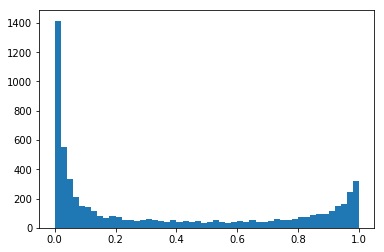

In [5]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i, dist_index[i]])

y_dist = np.array(y_dist)

f = plt.figure(figsize=(6, 4))

plt.hist(y_dist, bins=50)

plt.show()


In [6]:

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.


Evaluating model = 'aparent-resnet'
[ 0.72703308  0.         -0.04489375 -4.90866549  0.8091689   0.
 -0.08017703 -4.32134139]
Spearman r = 0.69
AP = 0.79
n = 5992


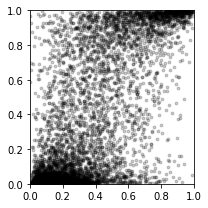

Evaluating model = 'aparent-resnet+hl'
[  0.68854364  -1.18009611  -0.06754297 -13.84989953   0.77394245
  -1.40992454  -0.12342388  -4.59732914]
Spearman r = 0.705
AP = 0.8
n = 5992


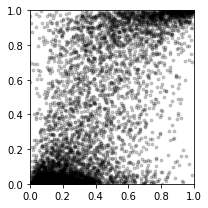

Evaluating model = 'aparent'
[  0.54730188   0.          -0.04190836  -9.423821     0.51528132
   0.          -0.05611711 -18.84577657]
Spearman r = 0.642
AP = 0.75
n = 5992


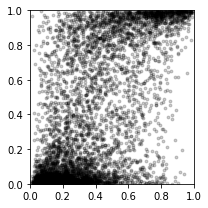

Evaluating model = 'deerect-apa'
[ 3.82004237e-01  0.00000000e+00 -6.12451104e-02 -1.03723416e+01
  6.57095303e-01  0.00000000e+00  6.72765688e-03 -2.22703178e+01]
Spearman r = 0.501
AP = 0.64
n = 5992


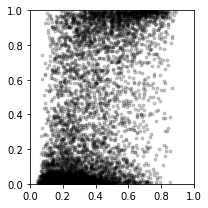

Evaluating model = 'polyapred'
[  0.23963287   0.          -0.06546853 -13.36951724   0.30538163
   0.          -0.04057478 -16.05460305]
Spearman r = 0.443
AP = 0.59
n = 5992


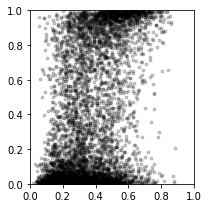

In [7]:
#Fit and evaluate regression / classification models on native measures

def logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask) :

    prox_exp = np.exp(w_prox_pas * s + w_prox_hl * hl + w_prox_len * l)
    dist_exp = np.exp(w_dist_pas * s + w_dist_hl * hl + w_dist_len * l)
    
    prox_score = np.sum(prox_exp * m * (1. - dist_mask), axis=1) + np.exp(w_prox_bias)
    dist_score = np.sum(dist_exp * m * dist_mask, axis=1) + np.exp(w_dist_bias)
    
    return dist_score / (dist_score + prox_score)

def logistic_model_mse(w_bundle, s, hl, m, l, dist_mask, y_true) :
    
    w_prox_pas = w_bundle[0]
    w_prox_hl = w_bundle[1]
    w_prox_len = w_bundle[2]
    w_prox_bias = w_bundle[3]
    w_dist_pas = w_bundle[4]
    w_dist_hl = w_bundle[5]
    w_dist_len = w_bundle[6]
    w_dist_bias = w_bundle[7]
    
    y_pred = logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = y_true_clip * np.log(y_true_clip / y_pred_clip) + (1. - y_true_clip) * np.log((1. - y_true_clip) / (1. - y_pred_clip))
    
    return np.mean(kl)

from sklearn.model_selection import KFold

def cross_val_model(s, hl, m, l, dist_mask, y_true, use_saluki=False, n_folds=10) :
    
    kf = KFold(n_splits=n_folds)
    
    y_pred = np.zeros(y_true.shape)
    
    for fold_ix, [train_index, test_index] in enumerate(kf.split(s)) :
        
        s_train, s_test = s[train_index], s[test_index]
        hl_train, hl_test = hl[train_index], hl[test_index]
        m_train, m_test = m[train_index], m[test_index]
        l_train, l_test = l[train_index], l[test_index]
        dist_mask_train, dist_mask_test = dist_mask[train_index], dist_mask[test_index]
        y_true_train = y_true[train_index]
        
        w0 = np.zeros(8)

        res = minimize(logistic_model_mse, w0, args=(s_train, hl_train if use_saluki else 0., m_train, l_train, dist_mask_train, y_true_train), method='BFGS', options={'disp': False})

        w_prox_pas = res.x[0]
        w_prox_hl = res.x[1]
        w_prox_len = res.x[2]
        w_prox_bias = res.x[3]
        w_dist_pas = res.x[4]
        w_dist_hl = res.x[5]
        w_dist_len = res.x[6]
        w_dist_bias = res.x[7]

        if fold_ix == 0 :
            print(res.x)

        y_pred[test_index] = logistic_model_predict(s_test, hl_test if use_saluki else 0., m_test, l_test, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask_test)
    
    return y_pred

model_spearman_rs = np.zeros(len(model_scores))
model_aps = np.zeros(len(model_scores))
model_y_dist_preds = np.zeros((y_dist.shape[0], len(model_scores)))

for model_ix in range(len(model_scores)) :
    
    print("Evaluating model = '" + model_names[model_ix] + "'")
    
    s = model_scores[model_ix]
    
    y_dist_pred = cross_val_model(s, hl, m, l, dist_mask, y_dist, use_saluki=use_saluki[model_ix], n_folds=20)
    
    spearman_r_val, _ = spearmanr(y_dist_pred, y_dist)
    model_spearman_rs[model_ix] = spearman_r_val
    
    y_labels = np.array([1. if y_dist[i] >= 0.5 else 0. for i in range(y_dist.shape[0])])
    
    ap = average_precision_score(y_labels, y_dist_pred)
    model_aps[model_ix] = ap
    model_y_dist_preds[:, model_ix] = y_dist_pred[:]

    print("Spearman r = " + str(round(spearman_r_val, 3)))
    print("AP = " + str(round(ap, 2)))
    print("n = " + str(y_dist.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(y_dist_pred, y_dist, color='black', s=8, alpha=0.2)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.tight_layout()
    plt.show()


In [10]:
#Save metrics

np.save("native_apa_multi_apadb_w_saluki_no_a_rich_filter_cv_20_spearman_rs", model_spearman_rs)
np.save("native_apa_multi_apadb_w_saluki_no_a_rich_filter_cv_20_aps", model_aps)
np.save("native_apa_multi_apadb_w_saluki_no_a_rich_filter_cv_20_y_dist_preds", model_y_dist_preds)
np.save("native_apa_multi_apadb_w_saluki_no_a_rich_filter_cv_20_orig_l", orig_l)
np.save("native_apa_multi_apadb_w_saluki_no_a_rich_filter_cv_20_hl", hl)
np.save("native_apa_multi_apadb_w_saluki_no_a_rich_filter_cv_20_y_dist", y_dist)


In [7]:
#Load metrics

model_spearman_rs_apadb = np.load("native_apa_multi_apadb_w_saluki_no_a_rich_filter_cv_20_spearman_rs.npy")
model_aps_apadb = np.load("native_apa_multi_apadb_w_saluki_no_a_rich_filter_cv_20_aps.npy")
model_y_dist_preds_apadb = np.load("native_apa_multi_apadb_w_saluki_no_a_rich_filter_cv_20_y_dist_preds.npy")
model_orig_l_apadb = np.load("native_apa_multi_apadb_w_saluki_no_a_rich_filter_cv_20_orig_l.npy")
model_hl_apadb = np.load("native_apa_multi_apadb_w_saluki_no_a_rich_filter_cv_20_hl.npy")
model_y_dist_apadb = np.load("native_apa_multi_apadb_w_saluki_no_a_rich_filter_cv_20_y_dist.npy")

model_spearman_rs_polyadb = np.load("native_apa_multi_polyadb_w_saluki_no_a_rich_filter_cv_20_spearman_rs.npy")
model_aps_polyadb = np.load("native_apa_multi_polyadb_w_saluki_no_a_rich_filter_cv_20_aps.npy")
model_y_dist_preds_polyadb = np.load("native_apa_multi_polyadb_w_saluki_no_a_rich_filter_cv_20_y_dist_preds.npy")
model_orig_l_polyadb = np.load("native_apa_multi_polyadb_w_saluki_no_a_rich_filter_cv_20_orig_l.npy")
model_hl_polyadb = np.load("native_apa_multi_polyadb_w_saluki_no_a_rich_filter_cv_20_hl.npy")
model_y_dist_polyadb = np.load("native_apa_multi_polyadb_w_saluki_no_a_rich_filter_cv_20_y_dist.npy")

model_spearman_rs_leslie = np.load("native_apa_multi_leslie_w_saluki_no_a_rich_filter_cv_20_spearman_rs.npy")
model_aps_leslie = np.load("native_apa_multi_leslie_w_saluki_no_a_rich_filter_cv_20_aps.npy")
model_y_dist_preds_leslie = np.load("native_apa_multi_leslie_w_saluki_no_a_rich_filter_cv_20_y_dist_preds.npy")
model_orig_l_leslie = np.load("native_apa_multi_leslie_w_saluki_no_a_rich_filter_cv_20_orig_l.npy")
model_hl_leslie = np.load("native_apa_multi_leslie_w_saluki_no_a_rich_filter_cv_20_hl.npy")
model_y_dist_leslie = np.load("native_apa_multi_leslie_w_saluki_no_a_rich_filter_cv_20_y_dist.npy")

model_spearman_rs_derti = np.load("native_apa_multi_derti_w_saluki_no_a_rich_filter_cv_20_spearman_rs.npy")
model_aps_derti = np.load("native_apa_multi_derti_w_saluki_no_a_rich_filter_cv_20_aps.npy")
model_y_dist_preds_derti = np.load("native_apa_multi_derti_w_saluki_no_a_rich_filter_cv_20_y_dist_preds.npy")
model_orig_l_derti = np.load("native_apa_multi_derti_w_saluki_no_a_rich_filter_cv_20_orig_l.npy")
model_hl_derti = np.load("native_apa_multi_derti_w_saluki_no_a_rich_filter_cv_20_hl.npy")
model_y_dist_derti = np.load("native_apa_multi_derti_w_saluki_no_a_rich_filter_cv_20_y_dist.npy")


APADB  Spearman r = [0.69, 0.7, 0.64, 0.5, 0.44]
Leslie Spearman r = [0.66, 0.67, 0.59, 0.48, 0.42]
Derti  Spearman r = [0.6, 0.6, 0.6, 0.37, 0.35]


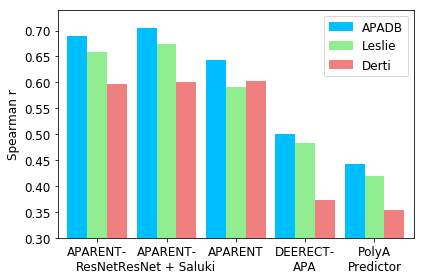

APADB  AP = [0.79, 0.8, 0.75, 0.64, 0.59]
Leslie AP = [0.79, 0.8, 0.74, 0.65, 0.59]
Derti  AP = [0.73, 0.73, 0.73, 0.58, 0.56]


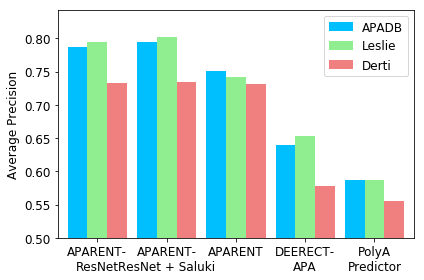

In [8]:

print("APADB  Spearman r = " + str(np.round(model_spearman_rs_apadb, 2).tolist()))
print("Leslie Spearman r = " + str(np.round(model_spearman_rs_leslie, 2).tolist()))
print("Derti  Spearman r = " + str(np.round(model_spearman_rs_derti, 2).tolist()))

f = plt.figure(figsize=(6, 4))

plt.bar(np.arange(model_spearman_rs_apadb.shape[0]) * 3.5, model_spearman_rs_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_spearman_rs_leslie.shape[0]) * 3.5 + 1, model_spearman_rs_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_spearman_rs_derti.shape[0]) * 3.5 + 2, model_spearman_rs_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 17)
plt.ylim(0.3)

plt.xticks([1, 4.5, 8, 11.5, 15], ['APARENT-\nResNet', 'APARENT-\nResNet + Saluki', 'APARENT', 'DEERECT-\nAPA', 'PolyA\nPredictor'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Spearman r', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_eval_bars_spearman_r.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_eval_bars_spearman_r.eps")

plt.show()


print("APADB  AP = " + str(np.round(model_aps_apadb, 2).tolist()))
print("Leslie AP = " + str(np.round(model_aps_leslie, 2).tolist()))
print("Derti  AP = " + str(np.round(model_aps_derti, 2).tolist()))

f = plt.figure(figsize=(6, 4))

plt.bar(np.arange(model_aps_apadb.shape[0]) * 3.5, model_aps_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_aps_leslie.shape[0]) * 3.5 + 1, model_aps_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_aps_derti.shape[0]) * 3.5 + 2, model_aps_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 17)
plt.ylim(0.5)

plt.xticks([1, 4.5, 8, 11.5, 15], ['APARENT-\nResNet', 'APARENT-\nResNet + Saluki', 'APARENT', 'DEERECT-\nAPA', 'PolyA\nPredictor'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Average Precision', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_eval_bars_ap.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_eval_bars_ap.eps")

plt.show()


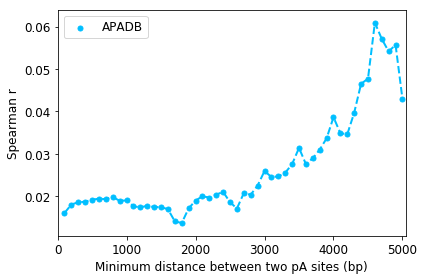

total_n = 5992


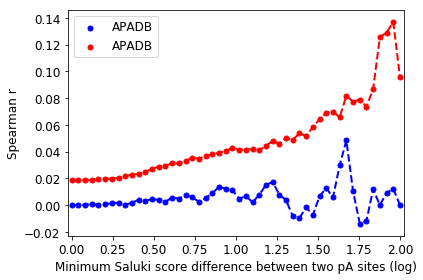

ns_vals_short_isoforms = [820 818 799 773 746 708 663 625 581 530 491 461 428 390 349 323 298 280
 266 249 231 217 201 186 167 154 138 128 118 105  96  89  83  74  67  56
  50  43  41  38  34  32  28  23  21  16  13  11  10   7]
ns_vals_long_isoforms = [5172 5160 5124 5068 4979 4827 4665 4452 4239 3998 3749 3483 3220 2967
 2734 2522 2314 2107 1923 1759 1590 1448 1320 1204 1086  954  834  744
  662  589  521  459  402  352  305  267  231  200  177  146  121   99
   83   75   64   53   36   29   28   24]


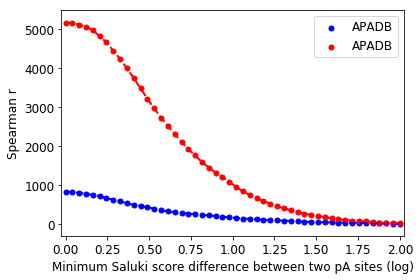

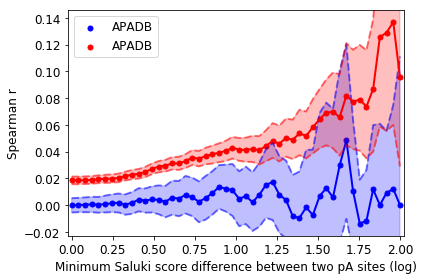

In [15]:
#Analyze improvement of Saluki

model_y_dist_preds = [
    model_y_dist_preds_apadb,
]

model_y_dists = [
    model_y_dist_apadb,
]

model_orig_ls = [
    model_orig_l_apadb,
]

model_hls = [
    model_hl_apadb,
]

data_names = ["APADB"]
data_colors = ["deepskyblue"]

#By minimum distance between two sites

max_l_cutoffs = np.linspace(100, 5000, 50)

f = plt.figure(figsize=(6, 4))

for model_y_dist_pred, y_dist, orig_l, hl, data_name, data_color in zip(model_y_dist_preds, model_y_dists, model_orig_ls, model_hls, data_names, data_colors) :

    y_dist_pred_old = model_y_dist_pred[:, 0]
    y_dist_pred = model_y_dist_pred[:, 1]

    r_vals = []
    for max_l_cutoff in max_l_cutoffs.tolist() :
        keep_index = np.max(orig_l, axis=-1) >= max_l_cutoff

        r_vals.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])

    r_vals = np.array(r_vals)

    plt.plot(max_l_cutoffs, r_vals, color=data_color, linewidth=2, linestyle='--')
    plt.scatter(max_l_cutoffs, r_vals, s=25, color=data_color, label=data_name)

plt.xlim(0, 5050)
#plt.ylim(0.01, 0.065)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Minimum distance between two pA sites (bp)", fontsize=12)
plt.ylabel("Spearman r", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_min_distance_curve.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_min_distance_curve.eps")

plt.show()

#By maximum difference in Saluki score

print("total_n = " + str(model_y_dist_preds[0][:, 0].shape[0]))

isoform_len_cutoff = 250

diff_hl_cutoffs = np.linspace(0., 2.0, 50)

for model_y_dist_pred, y_dist, orig_l, hl, data_name, data_color in zip(model_y_dist_preds, model_y_dists, model_orig_ls, model_hls, data_names, data_colors) :

    y_dist_pred_old = model_y_dist_pred[:, 0]
    y_dist_pred = model_y_dist_pred[:, 1]

    ns_vals_short_isoforms = []
    r_vals_short_isoforms = []
    for diff_hl_cutoff in diff_hl_cutoffs.tolist() :
        keep_index = (np.max(hl, axis=-1) - np.min(hl, axis=-1) >= diff_hl_cutoff) & (np.max(orig_l, axis=-1) <= isoform_len_cutoff)

        ns_vals_short_isoforms.append(np.sum(keep_index))
        r_vals_short_isoforms.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])

    ns_vals_short_isoforms = np.array(ns_vals_short_isoforms)
    r_vals_short_isoforms = np.array(r_vals_short_isoforms)
    
    ns_vals_long_isoforms = []
    r_vals_long_isoforms = []
    for diff_hl_cutoff in diff_hl_cutoffs.tolist() :
        keep_index = (np.max(hl, axis=-1) - np.min(hl, axis=-1) >= diff_hl_cutoff) & (np.max(orig_l, axis=-1) > isoform_len_cutoff)

        ns_vals_long_isoforms.append(np.sum(keep_index))
        r_vals_long_isoforms.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])

    ns_vals_long_isoforms = np.array(ns_vals_long_isoforms)
    r_vals_long_isoforms = np.array(r_vals_long_isoforms)

    f = plt.figure(figsize=(6, 4))
    
    plt.plot(diff_hl_cutoffs, r_vals_short_isoforms, color='blue', linewidth=2, linestyle='--')
    plt.scatter(diff_hl_cutoffs, r_vals_short_isoforms, s=25, color='blue', label=data_name)
    
    plt.plot(diff_hl_cutoffs, r_vals_long_isoforms, color='red', linewidth=2, linestyle='--')
    plt.scatter(diff_hl_cutoffs, r_vals_long_isoforms, s=25, color='red', label=data_name)

    plt.xlim(-0.025, 2.025)
    plt.ylim(-0.023, 0.146)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Minimum Saluki score difference between two pA sites (log)", fontsize=12)
    plt.ylabel("Spearman r", fontsize=12)

    plt.legend(fontsize=12)

    plt.tight_layout()

    plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_min_hl_curve_" + data_name + ".png", transparent=True, dpi=300)
    plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_min_hl_curve_" + data_name + ".eps")

    plt.show()
    
    print("ns_vals_short_isoforms = " + str(ns_vals_short_isoforms))
    print("ns_vals_long_isoforms = " + str(ns_vals_long_isoforms))
    
    f = plt.figure(figsize=(6, 4))
    
    plt.plot(diff_hl_cutoffs, ns_vals_short_isoforms, color='blue', linewidth=2, linestyle='--')
    plt.scatter(diff_hl_cutoffs, ns_vals_short_isoforms, s=25, color='blue', label=data_name)
    
    plt.plot(diff_hl_cutoffs, ns_vals_long_isoforms, color='red', linewidth=2, linestyle='--')
    plt.scatter(diff_hl_cutoffs, ns_vals_long_isoforms, s=25, color='red', label=data_name)

    plt.xlim(-0.025, 2.025)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Minimum Saluki score difference between two pA sites (log)", fontsize=12)
    plt.ylabel("Spearman r", fontsize=12)

    plt.legend(fontsize=12)

    plt.tight_layout()

    plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_min_hl_curve_" + data_name + "_count.png", transparent=True, dpi=300)
    plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_min_hl_curve_" + data_name + "_count.eps")

    plt.show()

#By maximum difference in Saluki score (bootstrap)

n_bootstrap = 10000

isoform_len_cutoff = 250

diff_hl_cutoffs = np.linspace(0., 2.0, 50)

for model_y_dist_pred, y_dist, orig_l, hl, data_name, data_color in zip(model_y_dist_preds, model_y_dists, model_orig_ls, model_hls, data_names, data_colors) :

    y_dist_pred_old = model_y_dist_pred[:, 0]
    y_dist_pred = model_y_dist_pred[:, 1]

    r_vals_short_isoforms = []
    r_vals_short_isoforms_lower = []
    r_vals_short_isoforms_upper = []
    for diff_hl_cutoff in diff_hl_cutoffs.tolist() :
        keep_index = (np.max(hl, axis=-1) - np.min(hl, axis=-1) >= diff_hl_cutoff) & (np.max(orig_l, axis=-1) <= isoform_len_cutoff)

        r_vals_short_isoforms.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])
        
        r_vals_short_isoforms_bootstrap = []
        for bootstrap_ix in range(n_bootstrap) :
            sel_index = np.nonzero(keep_index)[0].tolist()
            sel_index = np.random.choice(sel_index, size=(len(sel_index),), replace=True)
            
            r_vals_short_isoforms_bootstrap.append(spearmanr(y_dist_pred[sel_index], y_dist[sel_index])[0] - spearmanr(y_dist_pred_old[sel_index], y_dist[sel_index])[0])
        
        r_vals_short_isoforms_lower.append(np.quantile(r_vals_short_isoforms_bootstrap, q=0.1))
        r_vals_short_isoforms_upper.append(np.quantile(r_vals_short_isoforms_bootstrap, q=0.9))

    r_vals_short_isoforms = np.array(r_vals_short_isoforms)
    r_vals_short_isoforms_lower = np.array(r_vals_short_isoforms_lower)
    r_vals_short_isoforms_upper = np.array(r_vals_short_isoforms_upper)
    
    r_vals_long_isoforms = []
    r_vals_long_isoforms_lower = []
    r_vals_long_isoforms_upper = []
    for diff_hl_cutoff in diff_hl_cutoffs.tolist() :
        keep_index = (np.max(hl, axis=-1) - np.min(hl, axis=-1) >= diff_hl_cutoff) & (np.max(orig_l, axis=-1) > isoform_len_cutoff)

        r_vals_long_isoforms.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])
        
        r_vals_long_isoforms_bootstrap = []
        for bootstrap_ix in range(n_bootstrap) :
            sel_index = np.nonzero(keep_index)[0].tolist()
            sel_index = np.random.choice(sel_index, size=(len(sel_index),), replace=True)
            
            r_vals_long_isoforms_bootstrap.append(spearmanr(y_dist_pred[sel_index], y_dist[sel_index])[0] - spearmanr(y_dist_pred_old[sel_index], y_dist[sel_index])[0])
        
        r_vals_long_isoforms_lower.append(np.quantile(r_vals_long_isoforms_bootstrap, q=0.1))
        r_vals_long_isoforms_upper.append(np.quantile(r_vals_long_isoforms_bootstrap, q=0.9))

    r_vals_long_isoforms = np.array(r_vals_long_isoforms)
    r_vals_long_isoforms_lower = np.array(r_vals_long_isoforms_lower)
    r_vals_long_isoforms_upper = np.array(r_vals_long_isoforms_upper)

    f = plt.figure(figsize=(6, 4))
    
    plt.plot(diff_hl_cutoffs, r_vals_short_isoforms_lower, color='blue', alpha=0.5, linewidth=2, linestyle='--')
    plt.plot(diff_hl_cutoffs, r_vals_short_isoforms, color='blue', linewidth=2, linestyle='-')
    plt.plot(diff_hl_cutoffs, r_vals_short_isoforms_upper, color='blue', alpha=0.5, linewidth=2, linestyle='--')
    plt.fill_between(diff_hl_cutoffs, r_vals_short_isoforms_lower, r_vals_short_isoforms_upper, color='blue', alpha=0.25)
    plt.scatter(diff_hl_cutoffs, r_vals_short_isoforms, s=25, color='blue', label=data_name)
    
    plt.plot(diff_hl_cutoffs, r_vals_long_isoforms_lower, color='red', alpha=0.5, linewidth=2, linestyle='--')
    plt.plot(diff_hl_cutoffs, r_vals_long_isoforms, color='red', linewidth=2, linestyle='-')
    plt.plot(diff_hl_cutoffs, r_vals_long_isoforms_upper, color='red', alpha=0.5, linewidth=2, linestyle='--')
    plt.fill_between(diff_hl_cutoffs, r_vals_long_isoforms_lower, r_vals_long_isoforms_upper, color='red', alpha=0.25)
    plt.scatter(diff_hl_cutoffs, r_vals_long_isoforms, s=25, color='red', label=data_name)

    plt.xlim(-0.025, 2.025)
    plt.ylim(-0.023, 0.146)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Minimum Saluki score difference between two pA sites (log)", fontsize=12)
    plt.ylabel("Spearman r", fontsize=12)

    plt.legend(fontsize=12)

    plt.tight_layout()

    plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_min_hl_curve_" + data_name + "_bootstrap.png", transparent=True, dpi=300)
    plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_min_hl_curve_" + data_name + "_bootstrap.eps")

    plt.show()


APADB   Spearman r = [0.69, 0.7, 0.64, 0.5, 0.44]
PolyADB Spearman r = [0.67, 0.67, 0.66, 0.54, 0.52]
Leslie  Spearman r = [0.66, 0.67, 0.59, 0.48, 0.42]
Derti   Spearman r = [0.6, 0.6, 0.6, 0.37, 0.35]


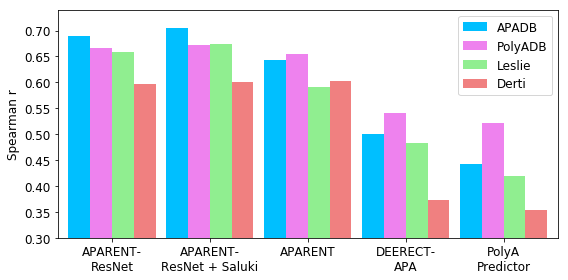

APADB   AP = [0.79, 0.8, 0.75, 0.64, 0.59]
PolyADB AP = [0.74, 0.75, 0.74, 0.61, 0.58]
Leslie  AP = [0.79, 0.8, 0.74, 0.65, 0.59]
Derti   AP = [0.73, 0.73, 0.73, 0.58, 0.56]


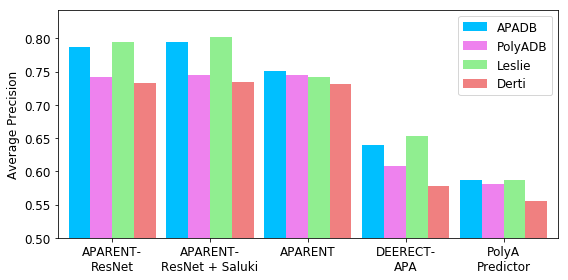

In [9]:

print("APADB   Spearman r = " + str(np.round(model_spearman_rs_apadb, 2).tolist()))
print("PolyADB Spearman r = " + str(np.round(model_spearman_rs_polyadb, 2).tolist()))
print("Leslie  Spearman r = " + str(np.round(model_spearman_rs_leslie, 2).tolist()))
print("Derti   Spearman r = " + str(np.round(model_spearman_rs_derti, 2).tolist()))

f = plt.figure(figsize=(8, 4))

plt.bar(np.arange(model_spearman_rs_apadb.shape[0]) * 4.5, model_spearman_rs_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_spearman_rs_polyadb.shape[0]) * 4.5 + 1, model_spearman_rs_polyadb, width=1., edgecolor='black', color='violet', linewidth=0, label='PolyADB')
plt.bar(np.arange(model_spearman_rs_leslie.shape[0]) * 4.5 + 2, model_spearman_rs_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_spearman_rs_derti.shape[0]) * 4.5 + 3, model_spearman_rs_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 22)
plt.ylim(0.3)

plt.xticks([1.5, 6, 10.5, 15, 19.5], ['APARENT-\nResNet', 'APARENT-\nResNet + Saluki', 'APARENT', 'DEERECT-\nAPA', 'PolyA\nPredictor'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Spearman r', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_and_polyadb_eval_bars_spearman_r.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_and_polyadb_eval_bars_spearman_r.eps")

plt.show()


print("APADB   AP = " + str(np.round(model_aps_apadb, 2).tolist()))
print("PolyADB AP = " + str(np.round(model_aps_polyadb, 2).tolist()))
print("Leslie  AP = " + str(np.round(model_aps_leslie, 2).tolist()))
print("Derti   AP = " + str(np.round(model_aps_derti, 2).tolist()))

f = plt.figure(figsize=(8, 4))

plt.bar(np.arange(model_aps_apadb.shape[0]) * 4.5, model_aps_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_aps_polyadb.shape[0]) * 4.5 + 1, model_aps_polyadb, width=1., edgecolor='black', color='violet', linewidth=0, label='PolyADB')
plt.bar(np.arange(model_aps_leslie.shape[0]) * 4.5 + 2, model_aps_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_aps_derti.shape[0]) * 4.5 + 3, model_aps_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 22)
plt.ylim(0.5)

plt.xticks([1.5, 6, 10.5, 15, 19.5], ['APARENT-\nResNet', 'APARENT-\nResNet + Saluki', 'APARENT', 'DEERECT-\nAPA', 'PolyA\nPredictor'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Average Precision', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_and_polyadb_eval_bars_ap.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_cv_20_no_a_rich_filter_and_polyadb_eval_bars_ap.eps")

plt.show()
